In [1]:
# Import Library
#!pip install torchtext spacy
import random
import torch, torchtext

from torchtext.legacy import data

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [2]:
import pandas as pd
df_train = pd.read_csv('dataset/train_aug.csv')
print("Length of Augmented train dataset: ",len(df_train))
df_valid = pd.read_csv('dataset/test_dev.csv')
print("Length of Test dataset: ",len(df_valid))

Length of Augmented train dataset:  13044
Length of Test dataset:  3311


In [3]:
df_train["Sentence"]=df_train["Sentence"].astype(str)
df_train["Label"] = df_train["Label"].astype(int)
df_valid["Sentence"]=df_valid["Sentence"].astype(str)
df_valid["Label"] = df_valid["Label"].astype(int)

In [7]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [8]:
Sentence = data.Field(sequential = True, tokenize = 'spacy', tokenizer_language= "en_core_web_sm",batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [9]:
fields = [('Sentence', Sentence),('Label',Label)]

In [10]:
example = [data.Example.fromlist([df_train.Sentence[i],df_train.Label[i]], fields) for i in range(df_train.shape[0])] 
train_dataset = data.Dataset(example, fields)
example = [data.Example.fromlist([df_valid.Sentence[i],df_valid.Label[i]], fields) for i in range(df_valid.shape[0])] 
valid_dataset = data.Dataset(example, fields)

In [11]:
import os, pickle

Sentence.build_vocab(train_dataset, max_size = 25000, vectors = "glove.6B.300d")
Label.build_vocab(train_dataset)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399196/400000 [00:41<00:00, 9424.12it/s]

In [12]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  19511
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 12021), (',', 10855), ('the', 9301), ('of', 6737), ('and', 6731), ('a', 6574), ('to', 4660), ('-', 3979), ('is', 3872), ("'s", 3585)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [14]:
import os, pickle
with open('pickle_files/train_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iterator = data.BucketIterator(train_dataset, batch_size = 32, 
                                                            sort_key = lambda x: len(x.Sentence),
                                                            sort_within_batch=True, device = device)


In [16]:
Sentence.build_vocab(valid_dataset, max_size = 25000, vectors = "glove.6B.300d")
Label.build_vocab(valid_dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valid_iterator = data.BucketIterator(valid_dataset, batch_size = 32, 
                                                            sort_key = lambda x: len(x.Sentence),
                                                            sort_within_batch=True, device = device)

with open('pickle_files/valid_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  10546
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 3128), (',', 2818), ('the', 2387), ('and', 1726), ('of', 1690), ('a', 1678), ('to', 1215), ('-', 1088), ("'s", 1002), ('is', 980)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx= pad_idx)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers, 
                               dropout=dropout,
                               bidirectional=True,
                               batch_first=True,
                               bias=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [29]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 256
num_output_nodes = 5
num_layers = 5
dropout = 0.65
pad_idx = Sentence.vocab.stoi[Sentence.pad_token]

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [30]:
print(model)

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(10546, 300, padding_idx=1)
  (encoder): LSTM(300, 256, num_layers=5, batch_first=True, dropout=0.65, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.65, inplace=False)
)
The model has 10,615,709 trainable parameters


In [31]:
pretrained_embeddings = Sentence.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0202, -0.2257,  0.0055,  ...,  0.4262,  0.2258,  0.2486],
        [ 0.0206, -0.2081,  0.4568,  ...,  0.4254,  0.2714, -0.1388]])

In [32]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [33]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.Sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.Label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.Label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.Sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.Label)
            acc = binary_accuracy(predictions, batch.Label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
import time
N_EPOCHS = 10
best_valid_loss = float('inf')
val_losses = []
train_losses = []

val_accuracy = []
train_accuracy = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)


    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'weights/saved_weights.pt')
    
    print(f'Epoch {epoch+1} | Time Taken: {(time.time() - start_time):.2f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')
     

Epoch 1 | Time Taken: 10.97s
	Train Loss: 1.573 | Train Acc: 30.02%
	 Val. Loss: 1.549 |  Val. Acc: 34.82% 

Epoch 2 | Time Taken: 11.00s
	Train Loss: 1.526 | Train Acc: 36.56%
	 Val. Loss: 1.515 |  Val. Acc: 37.65% 

Epoch 3 | Time Taken: 10.91s
	Train Loss: 1.487 | Train Acc: 40.50%
	 Val. Loss: 1.484 |  Val. Acc: 40.26% 

Epoch 4 | Time Taken: 10.88s
	Train Loss: 1.459 | Train Acc: 44.06%
	 Val. Loss: 1.476 |  Val. Acc: 41.35% 

Epoch 5 | Time Taken: 10.92s
	Train Loss: 1.439 | Train Acc: 46.10%
	 Val. Loss: 1.475 |  Val. Acc: 41.32% 

Epoch 6 | Time Taken: 10.91s
	Train Loss: 1.416 | Train Acc: 48.43%
	 Val. Loss: 1.472 |  Val. Acc: 42.03% 

Epoch 7 | Time Taken: 10.87s
	Train Loss: 1.397 | Train Acc: 50.49%
	 Val. Loss: 1.463 |  Val. Acc: 42.69% 

Epoch 8 | Time Taken: 10.87s
	Train Loss: 1.377 | Train Acc: 52.94%
	 Val. Loss: 1.470 |  Val. Acc: 41.99% 

Epoch 9 | Time Taken: 10.82s
	Train Loss: 1.362 | Train Acc: 54.46%
	 Val. Loss: 1.468 |  Val. Acc: 42.34% 

Epoch 10 | Time Tak

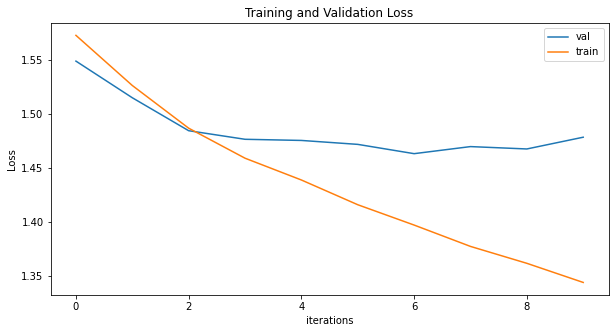

In [36]:
import matplotlib.pyplot  as plt
# Plotting the train and validation loss

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

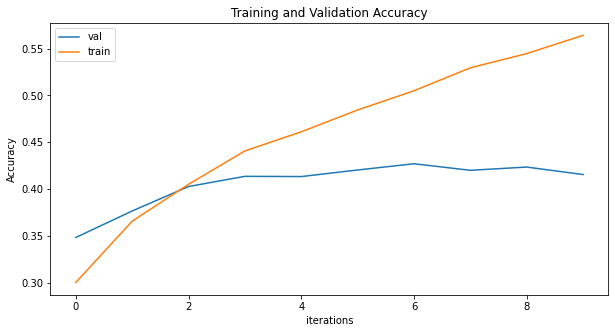

In [37]:
# Plotting the train and validation Accuracy

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [101]:
#load weights and tokenizer

path='weights/saved_weights.pt'
model.load_state_dict(torch.load(path))
model.eval();
tokenizer_file = open('pickle_files/valid_tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en_core_web_sm')

def classify_review(text):
    
    categories = {0: "Very Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Very Positive" }
    
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(text)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [102]:
import time
start_time = time.time()
sentiment = classify_review("""With a story inspired by the tumultuous surroundings of Los Angeles , 
                where feelings of marginalization loom for every dreamer with a burst bubble ,
                The Dogwalker has a few characters and ideas , 
                but it never manages to put them on the same path .""")
print("Time taken: ", time.time()-start_time)
print(sentiment)

Time taken:  0.019861698150634766
Negative


In [103]:
categories = {0: "Very Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Very Positive" }
df_valid["Sentiment"] = df_valid["Label"].apply(lambda x: categories.get(x))

In [115]:
df_valid["Predicted_Sentiment"] = df_valid["Sentence"].apply(lambda x: classify_review(x))
df_valid["Predicted_Label"] = df_valid["Predicted_Sentiment"].apply(lambda x: [k for k,v in categories.items() if v == x][0])

In [116]:
df_valid.to_csv("dataset/test_predicted.csv")

In [117]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
print(df_valid[['Sentence','Sentiment','Predicted_Sentiment','Label','Predicted_Label']].head(n=10))

                                                                                                                                                                                                                                                  Sentence      Sentiment Predicted_Sentiment  Label  Predicted_Label
0                                                                                                       For the first time in several years , Mr. Allen has surpassed himself with the magic he 's spun with the Hollywood empress of Ms. Leoni 's Ellie .       Positive            Negative      3                1
1                                                                                               Considering the harsh locations and demanding stunts , this must have been a difficult shoot , but the movie proves rough going for the audience as well .       Negative             Neutral      1                2
2               Christians sensitive to a reductionist view of their L

In [118]:
df_test_results_correct =  df_valid[df_valid["Sentiment"]==df_valid["Predicted_Sentiment"]].sample(25)
df_test_results_correct[['Sentence','Sentiment','Predicted_Sentiment']]

,Sentence,Sentiment,Predicted_Sentiment
464,"Soul is what 's lacking in every character in this movie and , subsequently , the movie itself .",Very Negative,Very Negative
1563,Here 's yet another studio horror franchise mucking up its storyline with glitches casual fans could correct in their sleep .,Very Negative,Very Negative
779,There is no pleasure in watching a child suffer .,Very Negative,Very Negative
2865,"Holy mad maniac in a mask , Splat-Man !",Neutral,Neutral
455,Viewers of `` The Ring '' are more likely to remember the haunting images than the plot holes .,Neutral,Neutral
1236,The film seems a dead weight .,Very Negative,Very Negative
2516,"Unfortunately , they 're sandwiched in between the most impossibly dry account of Kahlo 's life imaginable .",Negative,Negative
2526,A wildly inconsistent emotional experience .,Negative,Negative
1205,"This pep-talk for faith , hope and charity does little to offend , but if saccharine earnestness were a crime , the film 's producers would be in the clink for life .",Negative,Negative
1290,"Oft-described as the antidote to American Pie-type sex comedies , it actually has a bundle in common with them , as the film diffuses every opportunity for a breakthrough",Negative,Negative


In [121]:
df_test_false_positives =  df_valid.query('Sentiment in ["Negative","Very Negative"] and Predicted_Sentiment in ["Positive","Very Positive","Neutral"]')
df_test_false_positives[['Sentence','Sentiment','Predicted_Sentiment']].sample(25)


,Sentence,Sentiment,Predicted_Sentiment
28,"Very special effects , brilliantly bold colors and heightened reality ca n't hide the giant Achilles ' heel in `` Stuart Little 2 `` : There 's just no story , folks .",Negative,Neutral
1372,About as cutting-edge as Pet Rock : The Movie .,Very Negative,Neutral
2981,So few movies explore religion that it 's disappointing to see one reduce it to an idea that fits in a sampler .,Negative,Neutral
3031,Is this progress ?,Negative,Neutral
2503,But what are adults doing in the theater at all ?,Negative,Neutral
2949,"You really have to wonder how on earth anyone , anywhere could have thought they 'd make audiences guffaw with a script as utterly diabolical as this .",Very Negative,Neutral
2721,Credibility levels are low and character development a non-starter .,Very Negative,Neutral
2722,The experience of going to a film festival is a rewarding one ; the experiencing of sampling one through this movie is not .,Very Negative,Positive
2333,It takes talent to make a lifeless movie about the most heinous man who ever lived .,Negative,Neutral
1471,You 've seen them a million times .,Negative,Neutral


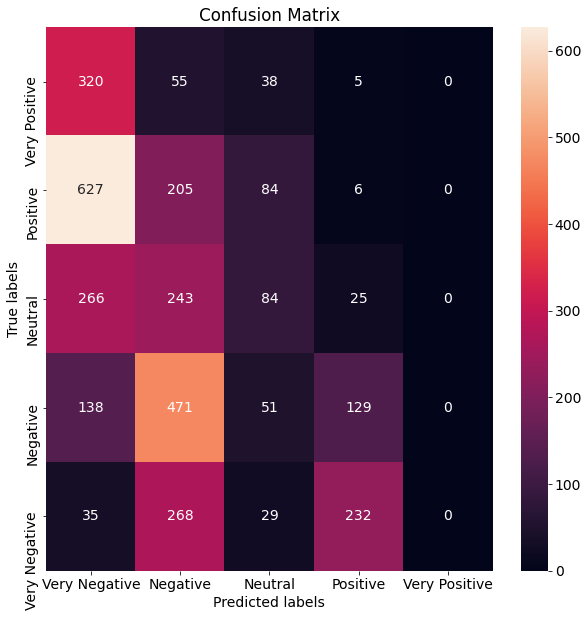

In [122]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_valid['Label'].values, df_valid['Predicted_Label'].values)

import seaborn as sns
import matplotlib.pyplot as plt     


font = {'font.size': 14}
plt.rcParams.update(font)
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(categories.values())); ax.yaxis.set_ticklabels(list(categories.values())[::-1]);



In [123]:
df_valid.Label.value_counts()

1    922
3    789
2    618
4    564
0    418
Name: Label, dtype: int64